# Clustering for uni-variate temperature 
Step of the codes :
- Import [modules](#modules) 
- Define [settings](#settings)  
- Define [functions](#functions)   
- [Download](#download) pc pred optim, pc_p1 and pc_obs
- [Clustering](#clustering) in PC space with k optimal
- [Identify members closest to centers](#centroids)
- [Download EOF](#download_EOF) 
- [Reconstruct](#reconstruct) centroids
- [Plot](#plot) centroids
- Compute [RMSE](#rmse)

# <a id='modules'>Import Modules</a>

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

## Clustering 
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedians import kmedians

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <a id='settings'>Settings</a>

### Variables

In [2]:
variables = ['tas']
var = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'
trunc = 18

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/home/globc/peatier/PPE/CNRMppe_save/PPE/ENSEMBLE2/files/npy/'
path_figures = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/Clustering/figures/'

# <a id='functions'>Functions</a>

In [4]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [5]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [6]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [7]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

# <a id='download'>Download PCs</a>

In [8]:
path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'

## PPE
path = path_files+'nc/'
filename = 'pc_PPE_'+var+'_PCvariance.nc'
pc_PPE = xr.open_mfdataset(path+filename,combine='by_coords')
dims_dict = {'time' : 'members', 'mode' : 'modes'}
pc_PPE = pc_PPE.rename_dims(dims_dict)
    
## observations
path = path_files+'nc/'
filename = 'pc_obs_'+var+'_PCvariance.nc'
pc_obs = xr.open_mfdataset(path+filename,combine='by_coords')
    
## p1 - the first line of pc_PPE
    
## predictions
path = path_files+'nc/'
filename = 'pc_pred_'+var+'_PCvariance.nc'
pc_pred = xr.open_mfdataset(path+filename,combine='by_coords')
pc_pred = pc_pred.rename({'__xarray_dataarray_variable__' : 'pcs'})

In [9]:
path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path = path_files+'nc/'
filename = 'optim_pc_PPE_'+var+'_PCvariance.nc'
pc_optim = xr.open_mfdataset(path+filename,combine='by_coords')

In [10]:
df_optim = pd.DataFrame()
for i in range(1,18,1) :
    df_optim['EOF '+str(i)] = pc_optim['EOF '+str(i)].values
df_optim['LHS index'] = pc_optim['LHS index'].values

In [11]:
df_optim

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,LHS index
0,5.051863,27.678013,5.304639,18.689382,-14.825190,-11.542253,-0.657514,6.842629,4.066359,-10.772724,4.288327,10.269911,2.679134,12.177464,3.537482,-2.101104,-4.288368,0
1,-4.794312,6.855708,-42.684800,-18.779768,5.158576,6.198050,-4.358292,-16.648680,6.376740,-7.562025,1.051029,15.032592,7.668564,9.160698,14.973822,-7.714201,4.807445,2
2,-0.141362,-23.431749,-37.124259,37.086812,-7.823608,-9.260247,4.645241,10.720741,-0.305186,1.841287,-1.919896,9.088627,13.174725,4.805849,-3.456038,11.186360,-4.054474,12
3,-12.060347,0.301641,-3.439717,7.079433,6.907833,-14.441940,4.204837,-9.672843,13.539515,8.508229,1.336494,8.764109,-7.786593,3.656761,6.843067,-3.819429,9.923059,23
4,14.548945,-12.721203,17.615812,7.553622,-15.835482,1.437697,-2.632686,-15.073162,9.042441,-6.345027,5.942962,-6.107267,-1.314257,-0.400537,-5.163583,-14.749335,13.037252,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8530,13.824362,-12.669765,36.603579,-8.352416,-3.313235,3.057613,-25.495083,-8.054668,-0.919050,10.514948,-0.708000,-12.112720,-11.751474,-9.293946,-7.038834,-4.283898,-2.469232,99952
8531,-4.017910,2.148134,-14.926100,15.150758,25.949692,-10.097147,12.131533,-2.203638,5.576600,-0.551301,-2.041759,3.800954,0.126398,-3.154666,6.194769,9.098019,2.659036,99964
8532,12.687250,-15.198558,-35.858974,8.588658,-55.970686,-19.156259,-15.938630,3.241821,-3.398548,-4.786232,4.433003,3.077738,8.894073,14.865298,-6.022804,5.864916,3.886221,99985
8533,-9.333616,34.405413,17.365748,-7.682058,2.346577,5.942638,4.320960,7.227939,8.040027,-1.694546,-1.336396,-7.829623,2.019127,5.477239,-5.279576,-7.244572,-10.333163,99988


# <a id='clustering'>Clustering analysis</a>

In [12]:
## Create the initial matrix to cluster 
list_index = []
for i in range(1,18,1) :
    tmp = 'EOF '+str(i)
    list_index.append(tmp)
    
tmp = df_optim[list_index].transpose().reset_index().drop(['index'], axis=1)
tmp_r = tmp.transpose()

In [13]:
n_clusters=10
kmean = KMeans(n_clusters).fit(tmp_r)

cluster = kmean.labels_
centers = kmean.cluster_centers_
dist_from_center = kmean.transform(tmp_r)

# <a id='centroids'>Members the closest to centroids</a>

In [14]:
list_index = []
for i in range(0,n_clusters,1) :
    tmp = 'dist_center_'+str(i+1)
    list_index.append(tmp)

dist_from_center = pd.DataFrame(dist_from_center, columns=list_index)
df_optim_cluster = pd.concat([df_optim, dist_from_center], axis=1)
df_optim_cluster['cluster'] = cluster

#group rows of DataFrame based on value in 'cluster' column
df_optim_cluster_grouped = df_optim_cluster.groupby(['cluster'])

In [15]:
index_closest_mb = []
pc_pseudo_centroids = []

for i in range(0,n_clusters,1) :
    
    #get all rows that belong to group name 'i'
    cluster = df_optim_cluster_grouped.get_group(i)
    cluster_sort = cluster.sort_values(['dist_center_'+str(i+1)])
    tmp = cluster_sort['LHS index'].iloc[0]
    index_closest_mb.append(tmp)
    
    ## Extract PC values 
    pc = df_optim[df_optim["LHS index"] == tmp].drop('LHS index', axis=1).values
    pc_pseudo_centroids.append(pc[0])

# <a id='download_EOF'>Download EOF solvers</a>

In [16]:
import pickle
path = path_files+'pkl/'

# open a file, where you stored the pickled data
file = open(path+'solver_'+var+'.pkl', 'rb')

# dump information to that file
solver = pickle.load(file)

# close the file
file.close()

In [54]:
eofs = {}
variances = {}
eofs = solver.eofsAsCovariance(pcscaling=0)
variances = solver.varianceFraction() 

In [55]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = 'tas_*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, ['tas'])

In [56]:
lat = p1_amip['lat']
lon = p1_amip['lon']
eofs_nb = arange(1,104,1)
eofs_xr = {}
eofs_combined = {}

eofs_xr = xr.DataArray(eofs, 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
## --Combine the modes for reconstruction
eofs_combined = eofs_xr

# <a id='reconstruct'>Reconstruct spatial fields</a>

In [57]:
## Centroïds
X_rec_pseudo_centroids = []
for i in pc_pseudo_centroids :
    pc = i
    X_rec_tmp = np.dot(eofs_combined[0:17,:,:].transpose(),pc)
    X_rec_pseudo_centroids.append(X_rec_tmp)

In [58]:
## Observations
X_rec_obs = np.dot(eofs_combined[0:17,:,:].transpose(),pc_obs['pseudo_pcs'][0:17].values)

In [59]:
xr_obs = xr.DataArray(X_rec_obs).to_dataset(name='tas')
xr_obs = xr_obs.rename_dims(dims_dict={'dim_0' : 'lon', 'dim_1' : 'lat'})
xr_obs = xr_obs.assign_coords({"lat": eofs_xr['lat'], 'lon' : eofs_xr['lon']})
xr_obs = xr_obs['tas'].transpose()
xr_obs

<xarray.DataArray 'tas' (lat: 128, lon: 256)>
array([[13.06242435, 13.06242435, 13.06242435, ..., 13.06242435,
        13.06242435, 13.06242435],
       [19.42951582, 19.42951582, 19.42951582, ..., 19.42951582,
        19.42951582, 19.42951582],
       [26.91905098, 26.91905098, 26.91905098, ..., 26.01878709,
        26.91905098, 26.91905098],
       ...,
       [16.15246645, 16.15246645, 16.15246645, ..., 16.09951881,
        16.15246645, 16.15246645],
       [14.20288879, 14.20288879, 14.20288879, ..., 14.20288879,
        14.20288879, 14.20288879],
       [10.72480492, 10.72480492, 10.72480492, ..., 10.72480492,
        10.72480492, 10.72480492]])
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

# Compute MSE

In [60]:
variable = 'tas'

In [61]:
path_file = path_files+'npy/'
filename = 'CNRMppe_decomposition_mean_'+str(variable)+'.npy'
Mean =  pd.read_pickle(path_file+filename).to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(variable)+'.npy')
W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(variable)+'.npy')
W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(variable)+'.npy')

In [62]:
MSE_centroids = []
for i in range(0,n_clusters,1) :
    xr_fig = xr.DataArray(X_rec_pseudo_centroids[i]).to_dataset(name='tas')
    xr_fig = xr_fig.rename_dims(dims_dict={'dim_0' : 'lon', 'dim_1' : 'lat'})
    xr_fig = xr_fig.assign_coords({"lat": eofs_xr['lat'], 'lon' : eofs_xr['lon']})
    xr_fig = xr_fig[variable].transpose()
    
    tmp = MSE_rec(xr_fig, xr_obs, Mean, W_rmse_2D)
    MSE_centroids.append(tmp)

In [63]:
MSE_centroids

[<xarray.DataArray ()>
 array(212865.4203462)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(103421.44595382)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(309777.99148515)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(262601.78501315)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(535707.11110693)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(189454.23034767)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(93467.63752585)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(237703.44154602)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(131438.46510841)
 Coordinates:
     mode     <U7 'tasmean', <xarray.DataArray ()>
 array(374739.07620948)
 Coordinates:
     mode     <U7 'tasmean']

# <a id='plot'>Plot</a>

In [64]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig(path_figures+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

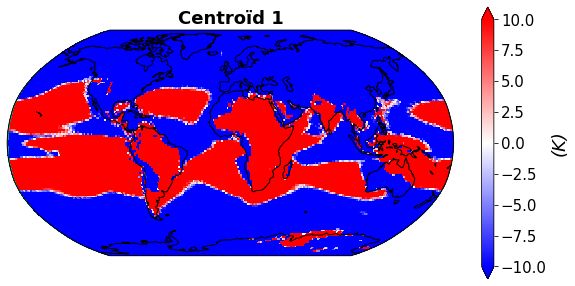

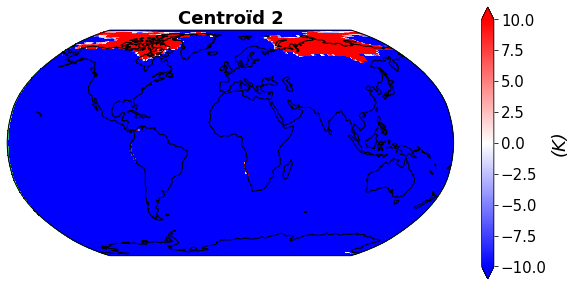

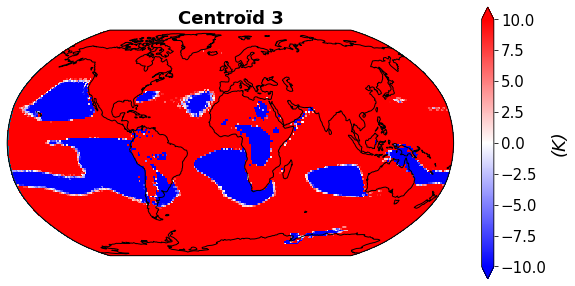

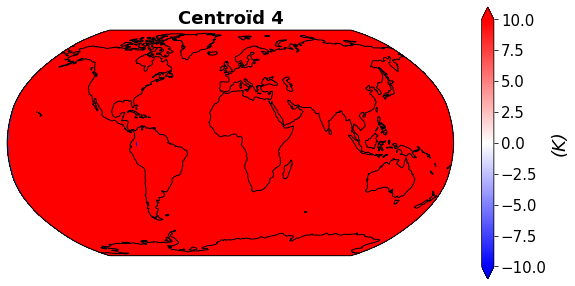

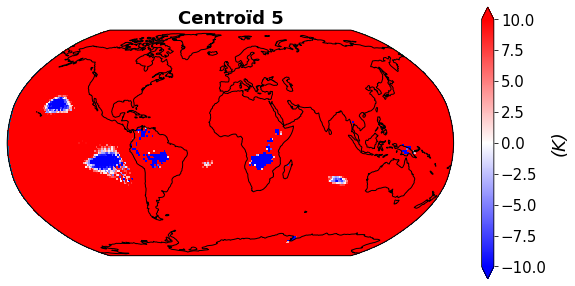

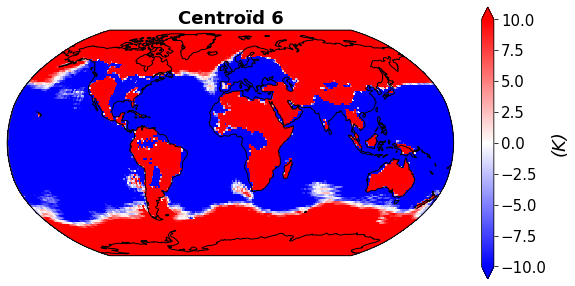

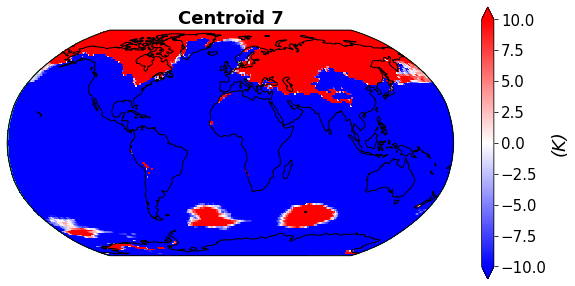

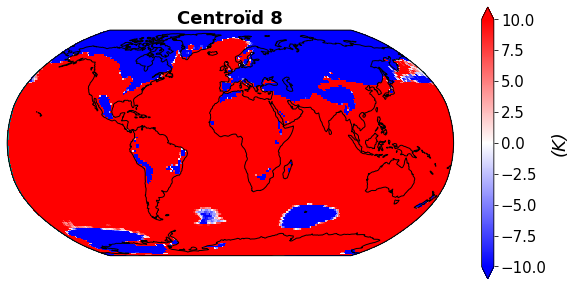

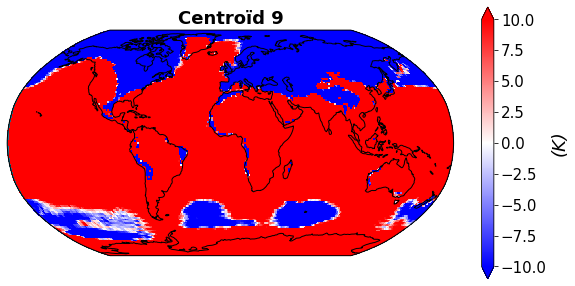

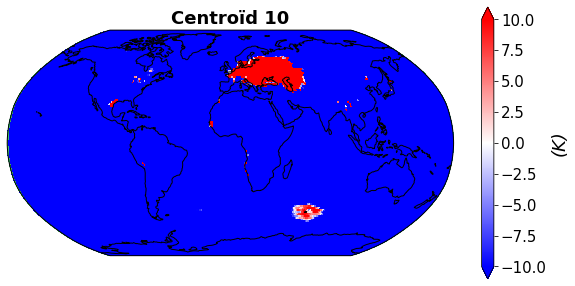

In [66]:
for i in range(0,n_clusters,1) :
    xr_fig = xr.DataArray(X_rec_pseudo_centroids[i]).to_dataset(name='tas')
    xr_fig = xr_fig.rename_dims(dims_dict={'dim_0' : 'lon', 'dim_1' : 'lat'})
    xr_fig = xr_fig.assign_coords({"lat": eofs_xr['lat'], 'lon' : eofs_xr['lon']})

    dataset = xr_fig.transpose() 
    var = dataset['tas'] - xr_obs#['tas']
    palette = "bwr"
    xmin = -10
    xmax = 10
    label = '(K)'
    title = 'Centroïd '+str(i+1)
    name_fig = 'Centroid_'+str(i+1)+'_spatial_PCvar.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)